In [4]:
import numpy as np
import logging
import random
import scipy.stats as st
from enum import Enum
from typing import List, Set

In [5]:
# Test functions --> change target_func for using each of them

def sphere(vector):  # Sphere target function
    return np.sum(np.power(vector, 2))
    
def rastrigin(vector, A=10):  # Rastrigin target function
    return A + np.sum(np.power(vector, 2) - A * np.cos(2*np.math.pi*vector))

def rosenbrock(vector, A=1, B=100):  # Rosenbrock target function
    return np.math.exp(-np.sum(np.array([(A*(vector[i+1]-vector[i]**2)**2 + (1-vector[i])**2)/B for i in range(len(vector) - 1)])))

In [25]:
class EvalMode(Enum):  # Evaluation modes --> minimum & maximum
    MINIMUM = 1
    MAXIMUM = 2


class Compare(Enum):  # Compare result
    IMPROVES = 1
    STAYS = 2  # Does not improve


class Utils:
    @staticmethod
    def compare(x1, x2, mode: EvalMode, target_fn) -> Compare:
        """
        Given a target function and a compare mode,
        tell if x2 improves x1

        Params:
            - x1 : position, np.ndarray type
            - x2 : position, np.ndarray type
            - mode: EvalMode type, if we're maximizing or minimizing
            - target_fn: target function

        Returns:
            - Compare type result, namely if x2 improves x1 or not
        """
        if mode == EvalMode.MAXIMUM:
            if target_fn(x2) > target_fn(x1):
                return Compare.IMPROVES
            else:
                return Compare.STAYS
        else:
            if target_fn(x2) < target_fn(x1):
                return Compare.IMPROVES
            else:
                return Compare.STAYS

    @staticmethod
    def around(f):
        """
        Keeps up to 5 decimals in given float type
        """
        return np.around(np.float128(f), 5)  # just save 5 decimals


class SearchSpace():
    def __init__(self, lower_bound: float, upper_bound: float):
        """
        Creates a bounded space. Dimensions are not specified, it'll allow N dimensions.

        Params:
            - lower_bound: float type, minimum value a coordenate can reach
            - upper_bound: float type, maximum value a coordenate can reach
        """
        self._lower_bound = Utils.around(lower_bound)
        self._upper_bound = Utils.around(upper_bound)

    @property
    def lower_bound(self) -> np.ndarray:
        return self._lower_bound

    @property
    def upper_bound(self) -> np.ndarray:
        return self._upper_bound

    def bounded(self, pos: np.ndarray) -> bool:
        """
        Checks if a given N-th dimensional array is bounded to the space created

        Params:
            - pos: np.ndarray type, whose coords are going to be checked
        
        Returns:
            - bounded: bool type, true if all coords are inside bounds, false otherwise
        """
        return np.all(np.array(
            [p >= self.lower_bound and p <= self._upper_bound for p in pos]
        ))

    def fix_position(self, pos: np.ndarray) -> np.ndarray:
        """
        Forces values that exceed bound to be in the border of them

        Params:
            - pos: array type, position to be checked and fixed
        
        Returns:
            - fixed position: np.ndarray type
        """
        _fxd_pos = []
        for p in pos:
            if p < self.lower_bound:
                _fxd_pos.append(self.lower_bound)
            elif p > self.upper_bound:
                _fxd_pos.append(self.upper_bound)
            else:
                _fxd_pos.append(p)
        return np.array(_fxd_pos)
    
    def random_bounded(self, dims: int) -> np.ndarray:
        """
        Returns a random position inside the bounds of the space

        Params:
            - dims: integer, number of dimensions desired for the position
        """
        return Utils.around(np.random.uniform(low=self.lower_bound, high=self.upper_bound, size=dims))


class Agent():
    def __init__(self, id: int, pos: np.ndarray):
        """
        Instantiates an agent given an identifier and a position
        """
        self._id = id
        self._hash = self._id.__hash__()
        self._trace = []
        self.update_position(pos)

    def __eq__(self, other):
        return self.name == other.name

    def __ne__(self, other):
        return not self == other

    def __hash__(self):
        self._hash

    def __str__(self):
        return f'Agent {self.id} @ [{self.pos}]'

    @property
    def pos(self):
        return self._pos

    @property
    def id(self):
        return self._id

    @property
    def trace(self):
        return self._trace

    def _add_trace(self, position: np.ndarray):
        self._trace.append(position)

    def update_position(self, position: np.ndarray):
        """Updates the position of the agent"""
        self._pos = np.array(Utils.around(position))    
        self._add_trace(self.pos)


class DifferentialEvolution():
    def __init__(self,\
        space: SearchSpace,
        n_agents: int,
        target_fn,
        dims,
        cr,
        f,
        mode: EvalMode
    ):
        """
        Instantiates DE class
        
        Params:
             - space: SearchSpace type with space bounds configuration
             - n_agents: number of agents to run
             - target_fn: target function to minimize or maximize
             - dims: number of dimensions to run
             - cr: crossover parameter
             - f: differential weight
             - mode: compare mode, maximize or minimize
        """
        self._space = space
        self._n_agents = n_agents
        self._target_fn = target_fn
        self._agents = dict(
            zip(
                [i for i in range(1, self._n_agents + 1)],
                [Agent(i, space.random_bounded(dims)) for i in range(1, self._n_agents + 1)]
            )
        )  # agents instances
        self._dims = dims
        self._cr = cr
        self._f = f
        self._mode = mode
        
        self._best_trace = []
        self._best_pos_trace = []
        
        self._performance_trace = []
        self._global_performance_trace = []
        self._update_performance(.0)
        self._updates = []

        self._update_best_pos(list(self.agents.values())[0].pos) # first agents' pos

        for a in list(self.agents.values())[1:]:  # search global best position from random start
            eval_res = Utils.compare(self.best_pos, a.pos, self.mode, self.target_fn)
            if eval_res == Compare.IMPROVES:
                self._update_best_pos(a.pos)

    @property
    def space(self) -> SearchSpace:
        return self._space
    
    @property
    def n_agents(self):
        return self._n_agents

    @property
    def target_fn(self):
        return self._target_fn

    @property
    def agents(self):
        return self._agents

    @property
    def dims(self):
        return self._dims

    @property
    def cr(self):
        return self._cr

    @property
    def f(self):
        return self._f

    @property
    def mode(self):
        return self._mode

    @property
    def best_trace(self):
        return self._best_trace

    @property
    def best_pos_trace(self):
        return self._best_pos_trace

    @property
    def best_pos(self):
        return self._best_pos

    @property
    def best(self):
        return self._best

    @property
    def updates(self):
        return self._updates

    @property
    def performance_trace(self):
        return self._performance_trace

    @property
    def global_performance_trace(self):
        return self._global_performance_trace

    def _update_best_pos(self, best_pos):
        """
        Updates pos and target_fn(pos) a.k.a. best pos & best
        """
        self._best_pos = np.float128(best_pos)
        self.__update_best(self.target_fn(self.best_pos))

    def _add_best_trace(self):
        self._best_pos_trace.append(self._best_pos)
        self._best_trace.append(self._best)

    def __update_best(self, best):
        """
        This is called by _update_best_pos
        """
        self._best = np.float128(best)

    def _update_performance(self, performance):
        self._performance_trace.append(performance)

    def _update_global_performance(self, performance):
        self._global_performance_trace.append(performance)

    def run(self, iterations: int):
        """
        Performs Differential Evolution 
        """
        __accepts = 0
        __global_accepts = 0
        for __iteration in range(iterations):  # Run for K iterations
            __updates = 0
            for id, agent in self.agents.items():  # Run for L agents
                __subagents = self.agents.copy()
                __subagents.pop(id)  # all agents except the one that it's iterating
                
                if len(__subagents) < 3:  # check [a,b,c] can be selected
                    logging.critical(f'Agent {id} has no three mates [a,b,c]. Error.')
                    
                __abc: List[Agent] = []
                for _ in range(0,3):  # select agents [a,b,c]
                    __abc.append(random.choice(list(__subagents.values())))
                    __subagents.pop(__abc[-1].id)  # remove selected agent of the availables so can't be repeatedly chosen

                candidate_pos = {}  # Current agent candidate position

                __i=0
                for coord in agent.pos:  # register current positions in candidate dictionary
                   candidate_pos[__i] = coord
                   __i+=1 
                
                dims_list: Set[int] = list(candidate_pos.keys())  # current coordinates indexes [0,1,2...n_dims]
                i_dim = random.choice(list(dims_list))  # select i_dim randomly
                candidate_pos[i_dim] = __abc[0].pos[i_dim] + self.f * (__abc[1].pos[i_dim] - __abc[2].pos[i_dim])  # x_i = a_i + F(b_i - c_i)
                dims_list.remove(i_dim)  # remove i_dim from the selectable dims so can't be chosen again
                
                for j_dim in dims_list:  # for each j_dim of the rest of dimensions
                    threshold = np.random.uniform(low=0, high=1)  # random number r_j
                    if threshold < self.cr:  # if r_j < CR then
                        candidate_pos[j_dim] = __abc[0].pos[j_dim] + self.f * (__abc[1].pos[j_dim] - __abc[2].pos[j_dim])  # x_j = a_j + F(b_j - c_j)
                
                candidate_refined = self.space.fix_position(np.array(list(candidate_pos.values())))  # Refine position with given space bounds

                if Utils.compare(agent.pos, candidate_refined, self.mode, self.target_fn) == Compare.IMPROVES:  # Fitness of the new position improves agent's position?
                    agent.update_position(candidate_refined)
                    __accepts += 1
                    if Utils.compare(self.best_pos, agent.pos, self.mode, self.target_fn) == Compare.IMPROVES:  # Fitness of the new position improves swarm position?
                        self._update_best_pos(agent.pos)
                        self._add_best_trace()
                        __updates += 1
                        __global_accepts += 1
                else:
                    agent.update_position(agent.pos)  # add trace in case position is not updated
            self._updates.append(__updates)
            self._update_performance(Utils.around(__accepts / ((__iteration + 1) * self.n_agents)))
            self._update_global_performance(Utils.around(__global_accepts / ((__iteration + 1) * self.n_agents)))

class Particle():
    def __init__(self, id: int, pos: np.ndarray, velocity: np.ndarray):
        """
        Instantiates an agent given an identifier and a position
        """
        self._id = id
        self._hash = self._id.__hash__()
        
        self._pos_trace = []
        self._velocity_trace = []

        self.update_position(pos)
        self.update_velocity(velocity)

        self._local_best_position = self.pos

    def __eq__(self, other):
        return self.name == other.name

    def __ne__(self, other):
        return not self == other

    def __hash__(self):
        self._hash

    def __str__(self):
        return f'Particle {self.id} @ [{self.pos}]'

    @property
    def pos(self):
        return self._pos

    @property
    def velocity(self):
        return self._velocity

    @property
    def id(self):
        return self._id

    @property
    def trace(self):
        return self._trace

    @property
    def local_best_position(self):
        return self._local_best_position

    def _add_pos_trace(self, position: np.ndarray):
        self._pos_trace.append(position)

    def _add_velocity_trace(self, position: np.ndarray):
        self._velocity_trace.append(position)

    def update_position(self, position: np.ndarray):
        """Updates the position of the agent"""
        self._pos = np.array(Utils.around(position))    
        self._add_pos_trace(self.pos)

    def update_velocity(self, velocity: np.ndarray):
        self._velocity = velocity
        self._add_velocity_trace(self.pos)

    def update_local_best(self, local_new_best: np.ndarray):
        self._local_best_position = local_new_best

class ParticleSystemOptimization():
    def __init__(self,\
        space: SearchSpace,
        n_particles: int,
        target_fn,
        dims,
        mode: EvalMode,
        min_vel,
        max_vel
    ):
        self._space = space
        self._n_particles = n_particles
        self._target_fn = target_fn
        self._particles = dict(
            zip(
                [i for i in range(1, self.n_particles + 1)],
                [Particle(i, space.random_bounded(dims), np.random.uniform(low=min_vel, high=max_vel, size=dims))
                    for i in range(1, self.n_particles + 1)]
            )
        )  # particles instances
        self._dims = dims
        self._mode = mode

        self._inertia_weight = st.norm(loc=1, scale=.5).rvs(size=1)
        self._tunnings = st.norm(loc=2, scale=.5).rvs(size=2)
        
        self._best_trace = []
        self._best_pos_trace = []
        
        self._performance_trace = []
        self._global_performance_trace = []
        self._update_performance(.0)
        self._updates = []

        self._update_best_pos(list(self.particles.values())[0].pos) # first particles' pos

        for p in list(self.particles.values())[1:]:  # search global best position from random start
            eval_res = Utils.compare(self.best_pos, p.pos, self.mode, self.target_fn)
            if eval_res == Compare.IMPROVES:
                self._update_best_pos(p.pos)

    @property
    def space(self) -> SearchSpace:
        return self._space
    
    @property
    def n_particles(self) -> int:
        return self._n_particles

    @property
    def target_fn(self):
        return self._target_fn

    @property
    def particles(self):
        return self._particles

    @property
    def dims(self):
        return self._dims

    @property
    def mode(self):
        return self._mode

    @property
    def inertia_weight(self):
        return self._inertia_weight

    @property
    def tunnings(self):
        return self._tunnings

    @property
    def best_trace(self):
        return self._best_trace

    @property
    def best_pos_trace(self):
        return self._best_pos_trace

    @property
    def best_pos(self):
        return self._best_pos

    @property
    def best(self):
        return self._best

    @property
    def updates(self):
        return self._updates

    @property
    def performance_trace(self):
        return self._performance_trace

    @property
    def global_performance_trace(self):
        return self._global_performance_trace

    def _update_best_pos(self, best_pos):
        """
        Updates pos and target_fn(pos) a.k.a. best pos & best
        """
        self._best_pos = np.float128(best_pos)
        self.__update_best(self.target_fn(self.best_pos))

    def _add_best_trace(self):
        self._best_pos_trace.append(self._best_pos)
        self._best_trace.append(self._best)

    def __update_best(self, best):
        """
        This is called by _update_best_pos
        """
        self._best = np.float128(best)

    def _update_performance(self, performance):
        self._performance_trace.append(performance)

    def _update_global_performance(self, performance):
        self._global_performance_trace.append(performance)

    def run(self, iterations: int):
        c1, c2 = self.tunnings
        __accepts = 0
        __global_accepts = 0
        for __iteration in np.arange(iterations):
            __updates = 0
            for particle in self.particles.values():
                particle.update_velocity(
                        self.inertia_weight * particle.velocity +\
                            c1*np.random.random()*(particle.local_best_position - particle.pos) +\
                                c2*np.random.random()*(self.best_pos - particle.pos)
                )

                particle.update_position(self.space.fix_position(particle.pos + particle.velocity))  # adds trace

                if Utils.compare(particle.local_best_position, particle.pos, self.mode, self.target_fn) == Compare.IMPROVES:
                    particle.update_local_best(particle.pos)
                    __accepts += 1
                if Utils.compare(self.best_pos, particle.local_best_position, self.mode, self.target_fn) == Compare.IMPROVES:
                    self._update_best_pos(particle.local_best_position)
                    self._add_best_trace()
                    __updates += 1
                    __global_accepts += 1

            self._updates.append(__updates)
            self._update_performance(Utils.around(__accepts / ((__iteration + 1) * self.n_particles)))
            self._update_global_performance(Utils.around(__global_accepts / ((__iteration + 1) * self.n_particles)))


In [100]:
# Configuration of the simulation
N_DIMS = 2  # Number of dimensions
N_AGENTS = N_PARTICLES = 10**2  # Number of agents
ITERATIONS = 10**4  # Number of iterations
LOW, HIGH = -25, 25  # Space bounds (bounds for each dimensions)
MIN_VEL, MAX_VEL = -5, 5  # Velocity of the particles of PSO
CR, FF = .65, 1.15  # crossover parameter, differential weight
MODE = EvalMode.MAXIMUM  # Choose between EvalMode.MAXIMUM and EvalMode.MINIMUM to minimize or maximize the value of the target function

In [101]:
def run_sim() -> DifferentialEvolution:
    target_func = rosenbrock  # [sphere | rastrigin | rosenbrock]

    ss = SearchSpace(LOW, HIGH)
    
    de = DifferentialEvolution(
        space=ss,
        n_agents=N_AGENTS,
        dims=N_DIMS,
        target_fn=target_func,
        mode=MODE,
        cr=CR,
        f=FF
    )

    pso = ParticleSystemOptimization(
        space=ss,
        n_particles=N_PARTICLES,
        target_fn=target_func,
        dims=N_DIMS,
        mode=MODE,
        min_vel=MIN_VEL,
        max_vel=MAX_VEL
    )

    de.run(ITERATIONS)  # RUN Differential Evolution
    pso.run(ITERATIONS)  # RUN Particle System Optimization

    print(f'DE final best:  {de.best_pos} @ eval_fn_result: {de.best}')
    print(f'PSO final best: {pso.best_pos} @ eval_fn_result: {pso.best}')

    return de, pso


de, pso = run_sim()

DE final best:  [1. 1.] @ eval_fn_result: 1.0
PSO final best: [1.00282 1.01276] @ eval_fn_result: 0.9999994146639607


## Evaluation

In [120]:
import matplotlib.pyplot as plt
INTERVAL = .1
NUM = 100

import seaborn as sns

sns.set()

from matplotlib import rc
from matplotlib import cm
from matplotlib.lines import Line2D

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

### Plot

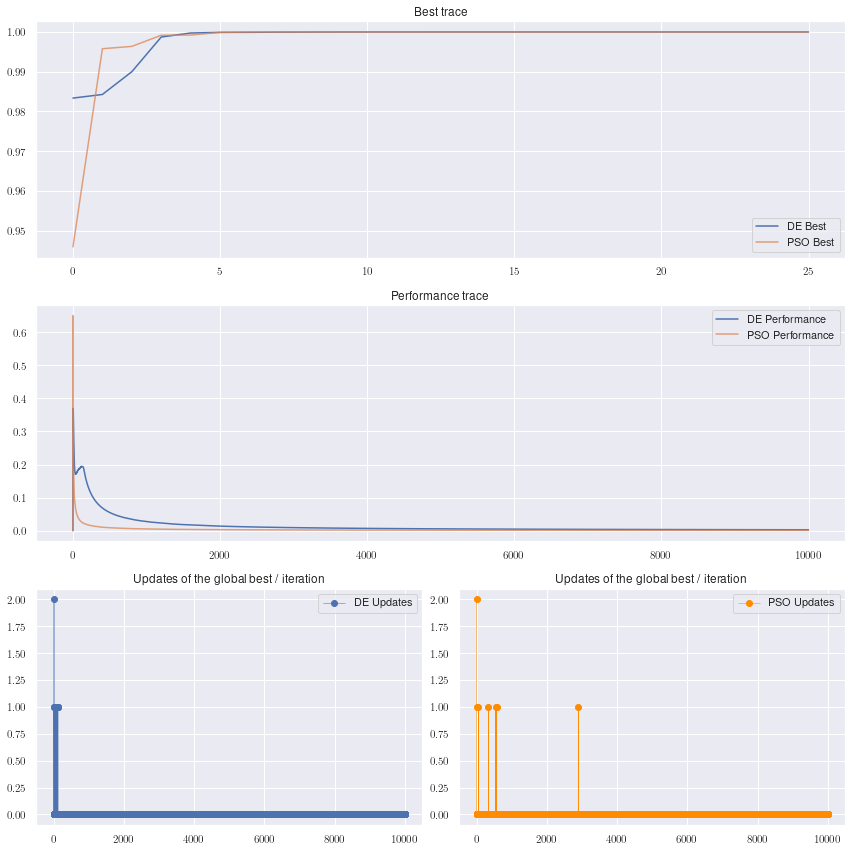

In [103]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax31 = fig.add_subplot(325)
ax32 = fig.add_subplot(326)

a1_xrange = 0, max(len(np.array(de.best_trace)), len(np.array(pso.best_trace)))
# a1_yrange = np.min([np.min(np.array(np.array(de.best_trace)), axis=0), np.min(np.array(np.array(pso.best_trace)), axis=0)]),\
#     np.max([np.max(np.array(np.array(de.best_trace)), axis=0), np.max(np.array(np.array(pso.best_trace)), axis=0)])

de_trace = list(de.best_trace.copy())
for _ in range(len(de_trace), a1_xrange[1]):  # Extend to match both of them
    de_trace.append(de_trace[-1])
pso_trace = list(pso.best_trace.copy())
for _ in range(len(pso_trace), a1_xrange[1]):  # Extend to match both of them
    pso_trace.append(pso_trace[-1])

ax1.set_title(label='Best trace')
ax1.plot(de_trace, label='DE Best')
ax1.plot(pso_trace, label='PSO Best', alpha=.75)
ax1.legend()

# a2_yrange = np.min([np.min(np.array(de.performance_trace), axis=0), np.min(np.array(pso.performance_trace), axis=0)]),\
#     np.max([np.max(np.array(de.performance_trace), axis=0), np.max(np.array(pso.performance_trace), axis=0)])

ax2.set_title(label='Performance trace')
ax2.plot(de.performance_trace, label='DE Performance')
ax2.plot(pso.performance_trace, label='PSO Performance', alpha=.75)
ax2.legend()

a3_yrange = np.min([np.min(np.array(de.updates), axis=0), np.min(np.array(pso.updates), axis=0)]),\
    np.max([np.max(np.array(de.updates), axis=0), np.max(np.array(pso.updates), axis=0)])

ax31.plot(de.updates, label='DE Updates', marker='o', linewidth=.5)
ax31.set_title(label='Updates of the global best / iteration')
ax31.set_ylim(a3_yrange[0] - 1e-1, a3_yrange[1] + 1e-1)
ax31.legend()

ax32.plot(pso.updates, label='PSO Updates', color='darkorange', marker='o', linewidth=.5)
ax32.set_title(label='Updates of the global best / iteration')
ax32.set_ylim(a3_yrange[0] - 1e-1, a3_yrange[1] + 1e-1)
ax32.legend()

fig.tight_layout()

### Global best position trace

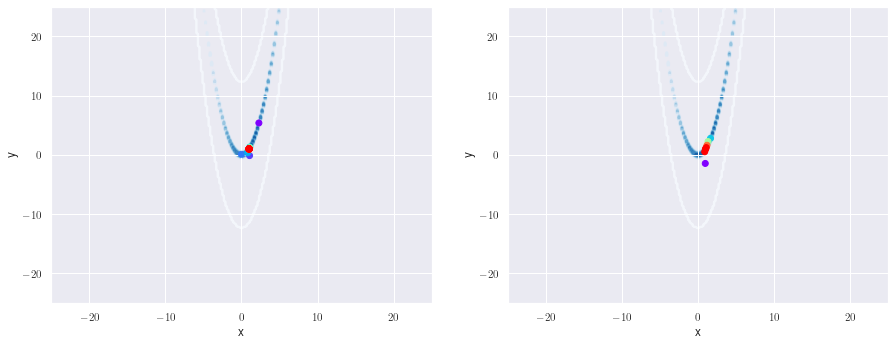

In [124]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
# ax3 = fig.add_subplot(212)

# Differential Evolution Scatter

x = np.array([__c[0] for __c in de.best_pos_trace])
y = np.array([__c[1] for __c in de.best_pos_trace])
colors = [i for i in range(len(x))]

cmap = cm.rainbow(np.array(colors)/np.mean(colors))

ax1.scatter(x, y, c=cmap)
ax1.set(xlim=(LOW, HIGH), ylim=(LOW, HIGH))

# Particle System Optimization Scatter

x = np.array([__c[0] for __c in pso.best_pos_trace])
y = np.array([__c[1] for __c in pso.best_pos_trace])
colors = [i for i in range(len(x))]

cmap = cm.rainbow(np.array(colors)/np.mean(colors))

ax2.scatter(x, y, c=cmap)
ax2.set(xlim=(LOW, HIGH), ylim=(LOW, HIGH))

# Plot rosenbrock lines

ros = lambda x, y, a, b: np.exp( -1/20. * ( (a-x)**2 + b*(y-x*x)**2 ) )

a, b = 1, 100
ymin, ymax = LOW, HIGH
xmin, xmax = LOW, HIGH
y = np.linspace(ymin, ymax, 250)
x = np.linspace(xmin, xmax, 250)

X, Y = np.meshgrid(x, y)
Z = ros(X, Y, a, b)

ax1.contour(X, Y, Z, linewidths=2.4, linestyles='solid', zorder=0, cmap='Blues', alpha=.75)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.contour(X, Y, Z, linewidths=2.4, linestyles='solid', zorder=0, cmap='Blues', alpha=.75)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Plot rainbow colors cheatsheet

# custom_lines = [Line2D([0], [0], color=cmap[i], lw=2) for i in range(len(colors))]
# ax3.legend(custom_lines, [str(s) for s in x], ncol=5,bbox_to_anchor=(1.1, 1.05))

plt.show()

pass

### eMSD (Ensemble Mean Squared Displacement)

In [277]:
def ensembled_mean_squared_displacement(walkers, steps):
        return np.array([np.linalg.norm(((walkers[:,i] - walkers[:,0])**2).mean()) for i in np.arange(0, steps)])

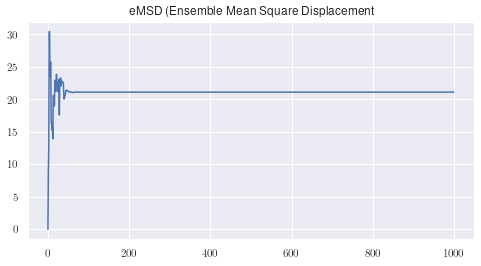

In [278]:
walkers = np.array([np.array(__agent.trace) for __agent in de.agents.values()])
eMSD = ensembled_mean_squared_displacement(walkers, ITERATIONS)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

ax.plot(eMSD)
ax.set_title(label='eMSD (Ensemble Mean Square Displacement')
pass

### Rosenbrock plot

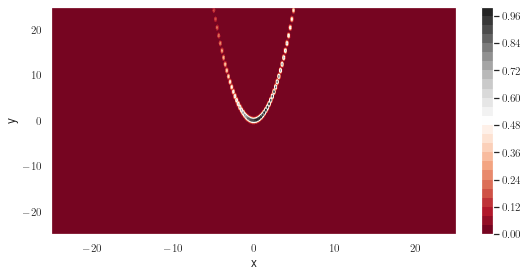

In [125]:
np.random.seed(124)

ros = lambda x, y, a, b: np.exp( -1/20. * ( (a-x)**2 + b*(y-x*x)**2 ) )

a, b = 1, 100
ymin, ymax = LOW, HIGH
xmin, xmax = LOW, HIGH
y = np.linspace(ymin, ymax, 250)
x = np.linspace(xmin, xmax, 250)

X, Y = np.meshgrid(x, y)
Z = ros(X, Y, a, b)


# Plot target function f(x,y)

# fig= plt.figure()
# ax = plt.axes(projection='3d')
# #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
# ax.contour3D(X, Y, Z, 75)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('f(x,y)');
# ax.set_title('Target distribution');


# plt.show()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)

cp = ax.contourf (X, Y, Z, 30, cmap='RdGy')
# cp = ax.contour(X, Y, Z, linewidths=2.4, linestyles='solid', zorder=0, cmap='Blues', alpha=.75)
fig.colorbar(cp);
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.tight_layout()

plt.show()